## Importing Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, jaccard_score
import plotly.express as px
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns
from graphviz import Digraph

## Loading the Data

In [2]:
df = pd.read_csv("Breast_Cancer.csv", header=0, delimiter=',')
df.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


## Dataset Inspection

In [3]:
numerical_cols = ['Age','Tumor Size','Regional Node Examined','Reginol Node Positive','Survival Months']
categorical_cols = ['Race','Marital Status','T Stage ','N Stage','6th Stage','differentiate','Grade','A Stage','Estrogen Status','Progesterone Status']

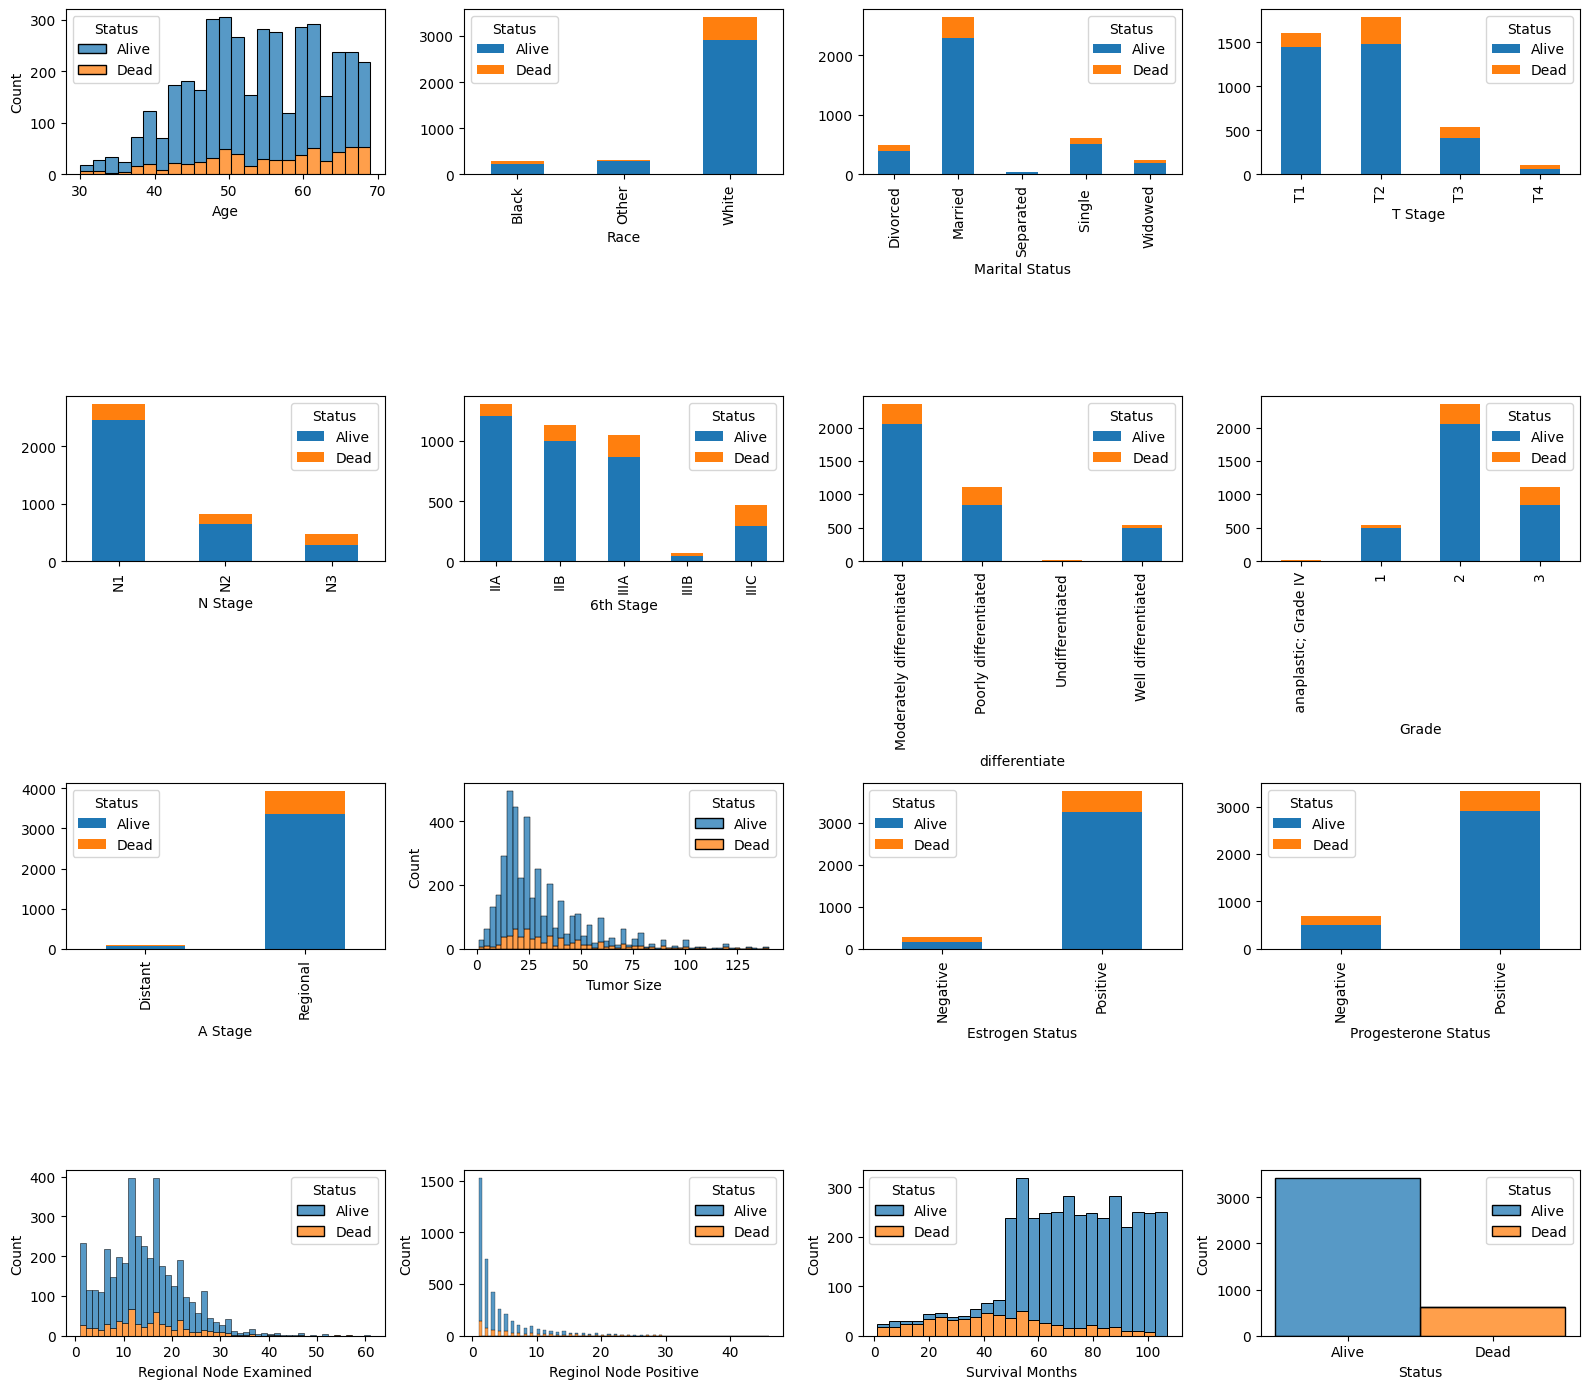

In [4]:
fig, axes = plt.subplots(4,4,figsize=(16,14))

for i, c in enumerate(df.columns):
    ax = axes.reshape(-1)[i]
    if c in categorical_cols:
        ct = pd.crosstab(index=df[c], columns=df['Status'])
        a = ct.plot(kind='bar', stacked=True,ax=ax)
    else: 
        sns.histplot(x=c,data=df, hue='Status',ax=ax, multiple='stack')
plt.tight_layout()

<Axes: >

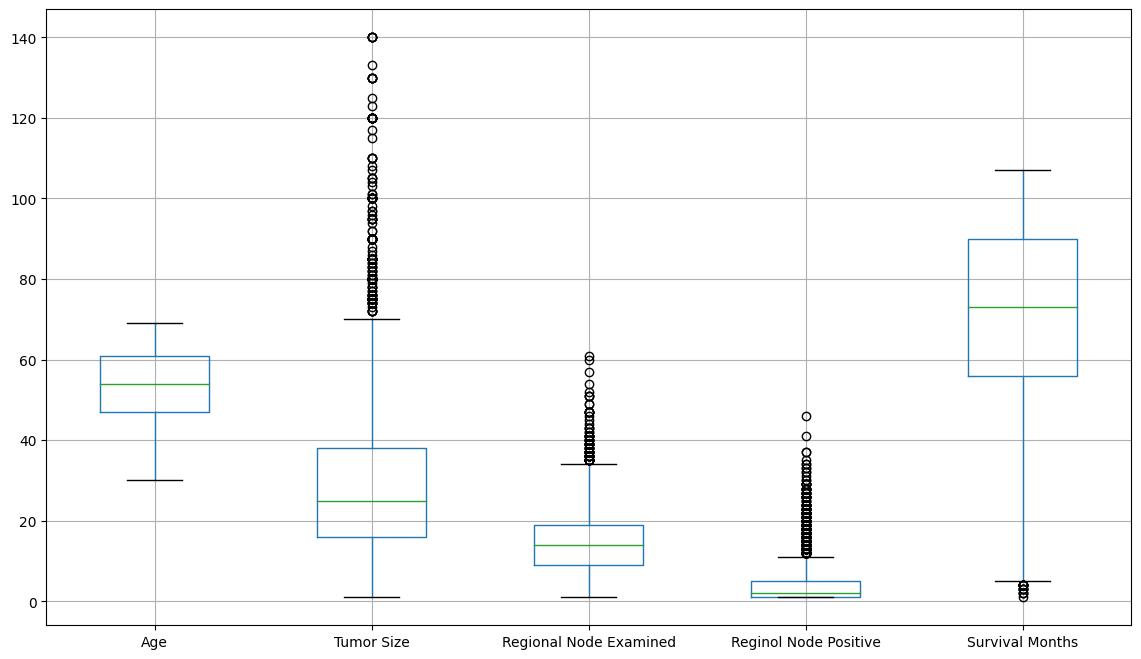

In [5]:
df.loc[:,numerical_cols].boxplot(figsize=(14,8))

## Transformations

<Axes: ylabel='Frequency'>

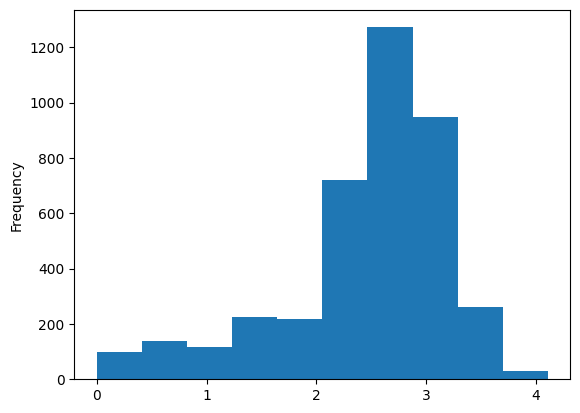

In [6]:
df['Regional Node Examined'] = df['Regional Node Examined'].apply('log')
df['Regional Node Examined'].plot.hist()


<Axes: ylabel='Frequency'>

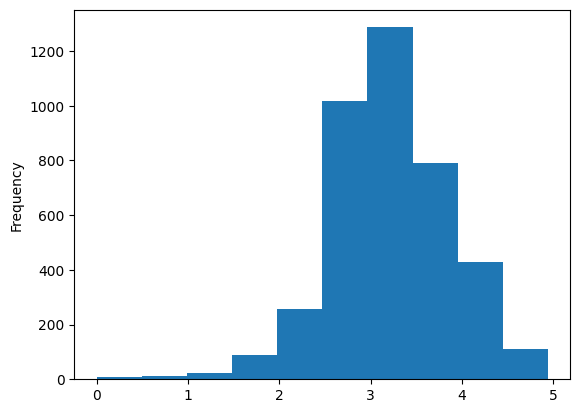

In [7]:
df['Tumor Size'] = df['Tumor Size'].apply('log')
df['Tumor Size'].plot.hist()

## Train Test Split

In [8]:
X = df.loc[:,df.columns != 'Status']
y = df['Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)


## Outlier Detection

<Axes: ylabel='Frequency'>

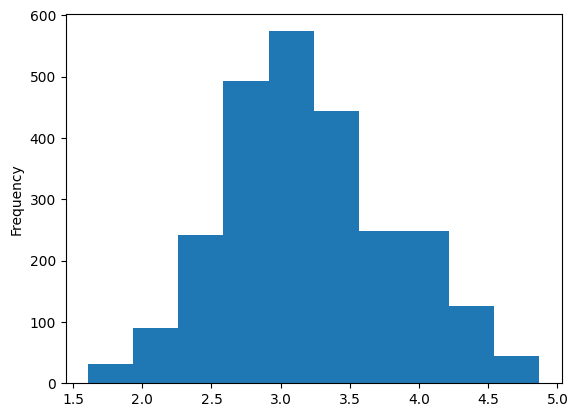

In [9]:
# Calculate the IQR range
Q1 = X_train['Tumor Size'].quantile(0.25)
Q3 = X_train['Tumor Size'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers for 'Tumor Size'
outliers_tumor_size = (X_train['Tumor Size'] < lower_bound) | (X_train['Tumor Size'] > upper_bound)

# Remove outliers from 'Tumor Size'
X_train = X_train[~outliers_tumor_size]
y_train = y_train[~outliers_tumor_size]

X_train['Tumor Size'].plot.hist()

<Axes: ylabel='Frequency'>

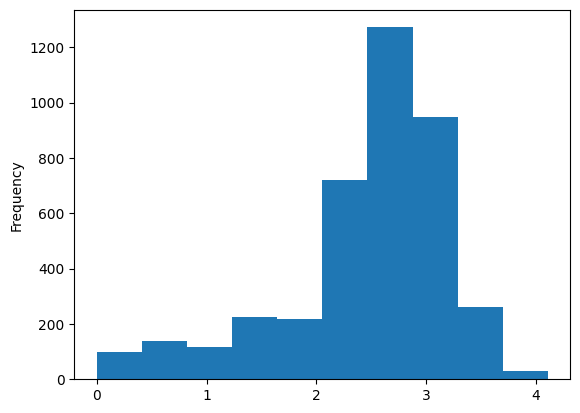

In [10]:
# Calculate the IQR range
Q1 = X_train['Regional Node Examined'].quantile(0.25)
Q3 = X_train['Regional Node Examined'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers for 'Regional Node Examined'
outliers_regional_node = (X_train['Regional Node Examined'] < lower_bound) | (X_train['Regional Node Examined'] > upper_bound)

# Remove outliers from 'Regional Node Examined'
X_train = X_train[~outliers_regional_node]
y_train = y_train[~outliers_regional_node]

df['Regional Node Examined'].plot.hist()

## Preprocessing

In [11]:
def preprocessing(X, y, scaler=None):
    # We scale all the columns
    if scaler is None: 
        # We only want the scaler to fit the train data
        scaler = MinMaxScaler()
        X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    else: 
        X[numerical_cols] = scaler.transform(X[numerical_cols])
    # One Hot Encoding
    X = pd.get_dummies(X, columns = categorical_cols)
    # Encode output
    status_map = {'Dead': 1, 'Alive': 0}
    y = y.map(status_map)
    y = y.rename('Dead')
    return X, y, scaler

X_train, y_train, scaler = preprocessing(X_train,y_train)
X_val, y_val, _ = preprocessing(X_val, y_val, scaler)
X_test, y_test, _ = preprocessing(X_test,y_test,scaler)
X_train.head()

,Age,Tumor Size,Regional Node Examined,Reginol Node Positive,Survival Months,Race_Black,Race_Other,Race_White,Marital Status_Divorced,Marital Status_Married,...,Grade_ anaplastic; Grade IV,Grade_1,Grade_2,Grade_3,A Stage_Distant,A Stage_Regional,Estrogen Status_Negative,Estrogen Status_Positive,Progesterone Status_Negative,Progesterone Status_Positive
844,0.794872,0.393154,0.479625,0.000000,0.924528,0,1,0,1,0,...,0,0,1,0,0,1,0,1,0,1
1993,0.256410,0.375611,0.293145,0.000000,0.471698,0,0,1,0,1,...,0,0,1,0,0,1,0,1,0,1
270,0.102564,0.762687,0.507318,0.177778,0.367925,0,0,1,0,1,...,0,0,1,0,1,0,0,1,0,1
1359,0.076923,0.268706,0.507318,0.022222,0.698113,0,0,1,0,1,...,0,1,0,0,0,1,0,1,0,1
2157,0.410256,0.831176,0.449521,0.022222,0.481132,0,0,1,0,1,...,0,0,1,0,0,1,0,1,0,1


## Data Balancing

In [12]:
print('Original dataset shape:', Counter(y_train))

Original dataset shape: Counter({0: 2006, 1: 368})


In [13]:
from imblearn.combine import SMOTEENN

# Apply SMOTEENN for combined oversampling and undersampling
smote_enn = SMOTEENN(sampling_strategy='minority')
X_train, y_train = smote_enn.fit_resample(X_train, y_train)

print('Resampled dataset shape:', Counter(y_train))


Resampled dataset shape: Counter({1: 1650, 0: 1339})


## Support Functions

In [14]:
results_df = pd.DataFrame(index=[], columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

In [15]:
def compute_metrics(y_real,y_pred):
    recall_class_1 =recall_score(y_real,y_pred, pos_label=1)
    f1_class_1 =f1_score(y_real,y_pred, pos_label=1)
    accuracy = accuracy_score(y_real,y_pred)
    f1_macro =f1_score(y_real,y_pred, average='macro')
    precison_macro =precision_score(y_real,y_pred,  average='macro')
    recall_macro =recall_score(y_real,y_pred,  average='macro')
    return [recall_class_1, f1_class_1, accuracy,f1_macro,precison_macro,recall_macro ]

def confusion(true, pred):
    """
    Function for pretty printing confusion matrices
    """
    pred = pd.Series(pred)
    true = pd.Series(true)
    
    true.name = 'target'
    pred.name = 'predicted'
    cm = pd.crosstab(true.reset_index(drop=True), pred.reset_index(drop=True))
    cm = cm[cm.index]
    return cm

## LDA

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)
y_pred_lda = lda_model.predict(X_val)
results_df.loc['LDA',:] = compute_metrics(y_val, y_pred_lda)
results_df

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.676768,0.538153,0.821429,0.713735,0.690945,0.762237


In [17]:
# Confusion matrix
confusion(y_val, y_pred_lda)

predicted,0,1
target,,
0,462,83
1,32,67


In [18]:
# Exploring LDA
X_transformed = lda_model.transform(X_train)

X_transformed = pd.DataFrame(X_transformed)
X_transformed['labels'] = y_train.reset_index(drop=True)
X_transformed

,0,labels
0,-1.806689,0
1,-0.755891,0
2,-2.646192,0
3,-0.914428,0
4,-1.508127,0
...,...,...
2984,-0.013372,1
2985,1.842623,1
2986,-1.370041,1
2987,2.538611,1


<Axes: xlabel='0'>

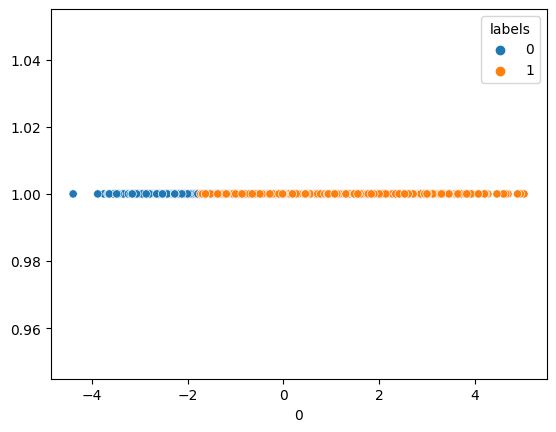

In [19]:
sns.scatterplot(x= 0, y= 1, data = X_transformed, hue='labels')

## KNN

In [20]:
from sklearn.neighbors import KNeighborsClassifier


index= pd.MultiIndex.from_arrays([[], []], names=('model', 'k'))
results_knn = pd.DataFrame(index=index, columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

k_values = range(1,50,2)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski')
    knn = knn.fit(X_train,y_train)
    y_pred = knn.predict(X_val)
    results_knn.loc[('KNN',k), :] = compute_metrics(y_val, y_pred)

sorted_results_knn = results_knn.sort_values(by='**Recall class 1**', ascending=False)
print(sorted_results_knn)

         **Recall class 1** **F1 class 1**  Accuracy  F1 Macro  \
model k                                                          
KNN   15           0.757576       0.432277  0.694099  0.611462   
      41           0.737374       0.430678  0.700311  0.613653   
      39           0.737374       0.429412  0.698758  0.612385   
      43           0.737374       0.426901  0.695652  0.609856   
      7            0.727273       0.421053  0.692547  0.605875   
      13           0.727273       0.421053  0.692547  0.605875   
      45           0.727273       0.422287  0.694099  0.607131   
      47           0.727273       0.417391  0.687888  0.602121   
      23           0.717172       0.420118  0.695652  0.606901   
      37           0.717172       0.434251  0.712733  0.620871   
      35           0.717172       0.438272  0.717391  0.624737   
      25           0.717172       0.438272  0.717391  0.624737   
      11           0.717172       0.422619  0.698758  0.609419   
      9   

In [21]:

# Retrieve the k value of the first row
first_row = sorted_results_knn.iloc[0]
k_value = first_row.name[1]

print("k value of the first row:", k_value)

knn = KNeighborsClassifier(n_neighbors=k_value)
knn = knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_val)
results_df.loc['KNN-'+str(k_value), :] = compute_metrics(y_val, y_pred_knn)
results_df.sort_values(by='**Recall class 1**', ascending=False)

k value of the first row: 15


,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-15,0.757576,0.432277,0.694099,0.611462,0.620907,0.720072
LDA,0.676768,0.538153,0.821429,0.713735,0.690945,0.762237


In [22]:
# Confusion matrix
confusion(y_val, y_pred_knn)

predicted,0,1
target,,
0,372,173
1,24,75


## Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression


index= pd.MultiIndex.from_arrays([[], []], names=('model', 'C'))
results_logreg = pd.DataFrame(index=index, columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

for l in lambdas:
    C = 1/l
    logreg = LogisticRegression(C=C, max_iter=1000, random_state=42)
    logreg = logreg.fit(X_train,y_train)
    y_pred = logreg.predict(X_val)
    results_logreg.loc[('LogReg', C), :] = compute_metrics(y_val, y_pred)

sorted_results_logreg = results_logreg.sort_values(by='**Recall class 1**', ascending=False)
sorted_results_logreg

**Recall class 1** **F1 class 1**  Accuracy  F1 Macro  \
model  C                                                                
LogReg 0.1                0.757576        0.49505  0.762422   0.66986   
       1.0                0.717172       0.527881  0.802795  0.701625   
       100000.0           0.666667       0.513619  0.805901  0.696189   
       10000.0            0.666667       0.513619  0.805901  0.696189   
       1000.0             0.666667       0.513619  0.805901  0.696189   
       100.0              0.666667       0.511628  0.804348  0.694649   
       10.0               0.666667       0.507692  0.801242  0.691589   

                Precision Macro Recall Macro  
model  C                                      
LogReg 0.1             0.656551     0.760439  
       1.0             0.679288      0.76776  
       100000.0         0.67491      0.74893  
       10000.0          0.67491      0.74893  
       1000.0           0.67491      0.74893  
       100.0           0.673527     0.748012  
       10.0            0.670807     0.746177

In [24]:
# Retrieve the k value of the first row
first_row = sorted_results_logreg.iloc[0]
c_value = first_row.name[1]

print("c value of the first row:", c_value)

logreg = LogisticRegression(C=c_value, max_iter=1000).fit(X_train,y_train)
y_pred_logreg = logreg.predict(X_val)
results_df.loc['LogReg-'+str(c_value), :] = compute_metrics(y_val, y_pred_logreg)

results_df.sort_values(by='**Recall class 1**', ascending=False)

c value of the first row: 0.1


,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-15,0.757576,0.432277,0.694099,0.611462,0.620907,0.720072
LogReg-0.1,0.757576,0.49505,0.762422,0.66986,0.656551,0.760439
LDA,0.676768,0.538153,0.821429,0.713735,0.690945,0.762237


In [25]:
# Confusion matrix
confusion(y_val, y_pred_logreg)

predicted,0,1
target,,
0,416,129
1,24,75


## Random Forest

In [26]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 300, 500],  # Number of trees in the forest
    'max_depth': [None, 5, 10],       # Maximum depth of each tree
    'min_samples_split': [2, 5, 10]   # Minimum number of samples required to split an internal node
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, 
                           param_grid=param_grid, 
                           scoring=['recall', 'f1','accuracy', 'f1_macro', 'precision_macro', 'recall_macro'],
                           cv=5,
                           refit='recall')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Print the best score found by GridSearchCV
print("Best Score:", grid_search.best_score_)

# Get the best model found by GridSearchCV
best_rfmodel = grid_search.best_estimator_


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.9751515151515152


In [27]:
y_pred_rf = best_rfmodel.predict(X_val)
results_df.loc['Random Forest', :] = compute_metrics(y_val, y_pred_rf)

results_df.sort_values(by='**Recall class 1**', ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-15,0.757576,0.432277,0.694099,0.611462,0.620907,0.720072
LogReg-0.1,0.757576,0.49505,0.762422,0.66986,0.656551,0.760439
Random Forest,0.686869,0.51711,0.802795,0.696604,0.675025,0.755361
LDA,0.676768,0.538153,0.821429,0.713735,0.690945,0.762237


In [28]:
# Confusion matrix
confusion(y_val, y_pred_rf)

predicted,0,1
target,,
0,449,96
1,31,68


## Feature Importance

<Axes: >

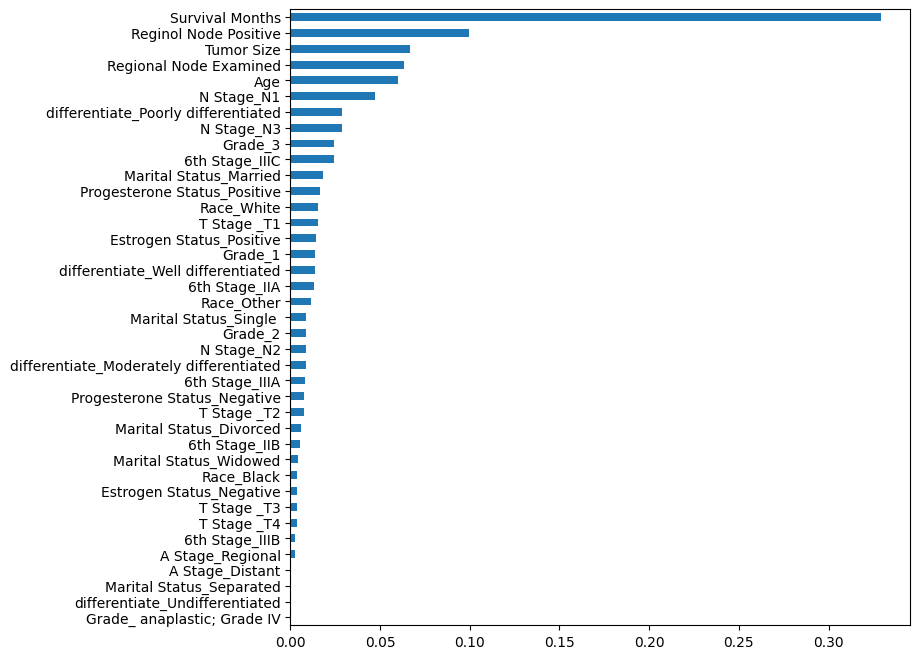

In [29]:
var_imp = pd.DataFrame({'importance': best_rfmodel.feature_importances_},
                       index=X_train.columns)

var_imp.sort_values(by='importance').plot.barh(figsize=(8,8),
                                               legend=False)

## Gaussian NB

In [30]:
from sklearn.naive_bayes import GaussianNB


gaussian_nb = GaussianNB()
gaussian_nb = gaussian_nb.fit(X_train[numerical_cols],y_train)
y_pred_gnb = gaussian_nb.predict(X_val[numerical_cols])

results_df.loc['Gaussian-NB', :] = compute_metrics(y_val, y_pred_gnb)
results_df.sort_values(by='**Recall class 1**', ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-15,0.757576,0.432277,0.694099,0.611462,0.620907,0.720072
LogReg-0.1,0.757576,0.49505,0.762422,0.66986,0.656551,0.760439
Gaussian-NB,0.727273,0.503497,0.779503,0.68089,0.662973,0.758132
Random Forest,0.686869,0.51711,0.802795,0.696604,0.675025,0.755361
LDA,0.676768,0.538153,0.821429,0.713735,0.690945,0.762237


## Neural Network

In [31]:
sizes = [2*i for i in range(1,3)]
sizes = sizes + [[2*i,2*i] for i in range(1,3)]
sizes = sizes + [[2*i,2*i, 2*i] for i in range(1,3)]

print(len(sizes), sizes)


decays = [0.01,0.1,1]
print(len(decays), decays[:10])

6 [2, 4, [2, 2], [4, 4], [2, 2, 2], [4, 4, 4]]
3 [0.01, 0.1, 1]


In [32]:
from sklearn.neural_network import MLPClassifier


model_nnet = MLPClassifier(hidden_layer_sizes=[2,2,2],
                           alpha=0,
                           activation='logistic',
                           max_iter=1000000,
                           solver='lbfgs',random_state=42)


trc = GridSearchCV(estimator=model_nnet,
                   scoring=['recall', 'f1','accuracy', 'f1_macro', 'precision_macro', 'recall_macro'],
                   param_grid={'hidden_layer_sizes': sizes,
                              'alpha': decays},
                   cv=5,
                   return_train_score=True,
                   refit='recall')


# Fit the GridSearchCV object to the data
trc.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", trc.best_params_)

# Print the best score found by GridSearchCV
print("Best Score:", trc.best_score_)

# Get the best model found by GridSearchCV
best_mlpmodel = trc.best_estimator_

c:\Users\nikol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\nikol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Best Parameters: {'alpha': 1, 'hidden_layer_sizes': [4, 4, 4]}
Best Score: 0.9606060606060606


In [33]:
y_pred_mlp = best_mlpmodel.predict(X_val)
results_df.loc['MLP', :] = compute_metrics(y_val, y_pred_mlp)

results_df.sort_values(by='**Recall class 1**', ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-15,0.757576,0.432277,0.694099,0.611462,0.620907,0.720072
LogReg-0.1,0.757576,0.49505,0.762422,0.66986,0.656551,0.760439
Gaussian-NB,0.727273,0.503497,0.779503,0.68089,0.662973,0.758132
Random Forest,0.686869,0.51711,0.802795,0.696604,0.675025,0.755361
LDA,0.676768,0.538153,0.821429,0.713735,0.690945,0.762237
MLP,0.666667,0.461538,0.76087,0.653923,0.640366,0.722324


In [34]:
# Confusion Matrix
confusion(y_val, y_pred_mlp)

predicted,0,1
target,,
0,424,121
1,33,66


## Ensemble

In [35]:
from sklearn.ensemble import VotingClassifier


voting_best = VotingClassifier([('logreg', logreg),
                                ('knn', knn),
                                ('rf', best_rfmodel)] ,voting='soft')
voting_best.fit(X_train, y_train)

y_pred = voting_best.predict(X_val)

results_df.loc['Ensemble', :] = compute_metrics(y_val, y_pred)

results_df.sort_values(by='**Recall class 1**', ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-15,0.757576,0.432277,0.694099,0.611462,0.620907,0.720072
LogReg-0.1,0.757576,0.49505,0.762422,0.66986,0.656551,0.760439
Gaussian-NB,0.727273,0.503497,0.779503,0.68089,0.662973,0.758132
Ensemble,0.727273,0.494845,0.771739,0.673702,0.657633,0.753545
Random Forest,0.686869,0.51711,0.802795,0.696604,0.675025,0.755361
LDA,0.676768,0.538153,0.821429,0.713735,0.690945,0.762237
MLP,0.666667,0.461538,0.76087,0.653923,0.640366,0.722324


## Generalization Performance

In [36]:
y_pred=logreg.predict(X_test)

In [39]:
print('recall score: ', recall_score(y_test,y_pred, pos_label=1))
print('f1 score: ', f1_score(y_test,y_pred, pos_label=1))
print('accuracy score: ', accuracy_score(y_test,y_pred))
print('f1 macro: ', f1_score(y_test,y_pred, average='macro'))
print('precision score: ', precision_score(y_test,y_pred,  average='macro'))
print('recall macro: ', recall_score(y_test,y_pred,  average='macro'))

fig = px.imshow(np.around(confusion_matrix(y_test, y_pred, normalize='true'),2), 
                template='ggplot2',
                text_auto=True, 
                aspect="True", 
                labels=dict(x="Predicted Label", y="Correct Label", color='Value'))
fig.update_xaxes(side="bottom")
fig.show()

recall score:  0.7317073170731707
f1 score:  0.47120418848167545
accuracy score:  0.7490683229813665
f1 macro:  0.6533545372375804
precision score:  0.6435253935253935
recall macro:  0.7419533652814534
